# Data preprocessing and augmentation

#### Dataset download

In [1]:
import kagglehub

path = kagglehub.dataset_download("slothkong/10-monkey-species")

#### Importing modules, libraries and dataset

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import random_split
from torch.utils.data import DataLoader, random_split
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    precision_recall_fscore_support,
    top_k_accuracy_score,
)
import seaborn as sns
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary


In [5]:
train_path = f"{path}/training/training"
validation_path = f"{path}/validation/validation"

In [6]:
print(train_path)
print(validation_path)

/kaggle/input/10-monkey-species/training/training
/kaggle/input/10-monkey-species/validation/validation


#### Creating datasets

In [7]:
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

valid_transform = transforms.Compose(
    [
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

train_dataset = datasets.ImageFolder(train_path)
validation_size = len(train_dataset) - int(0.9 * len(train_dataset))
validation_dataset, train_dataset = random_split(
    train_dataset, [validation_size, len(train_dataset) - validation_size]
)


validation_dataset.dataset.transform = valid_transform
train_dataset.dataset.transform = train_transform
test_dataset = datasets.ImageFolder(validation_path, transform=valid_transform)

print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(validation_dataset)}")
print(f"Number of test images: {len(test_dataset)}")


Number of training images: 987
Number of validation images: 110
Number of test images: 272


#### Create dataloaders

In [8]:
batch_size = 16
train_load = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_load = DataLoader(
    dataset=validation_dataset, batch_size=batch_size, shuffle=False
)
test_load = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

class_names = train_dataset.dataset.classes
print("Class Labels:", class_names)


Class Labels: ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']


# Model architecture

In [9]:
class CNNModel(nn.Module):
    """
    A Convolutional Neural Network (CNN) model for image classification.
    """

    def __init__(self):
        """
        Initializes the CNNModel.
        """
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, padding=1
        )
        self.conv3 = nn.Conv2d(
            in_channels=64, out_channels=256, kernel_size=3, padding=1
        )

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten_size = 256 * 28 * 28
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        """
        Defines the forward pass of the CNN.
        """
        x = self.pool(F.relu(self.conv1(x)))

        x = self.pool(F.relu(self.conv2(x)))

        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(-1, self.flatten_size)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


# Training


#### Define the model and constant variables

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)

In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 256, 56, 56]         147,712
         MaxPool2d-6          [-1, 256, 28, 28]               0
            Linear-7                  [-1, 128]      25,690,240
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 25,858,634
Trainable params: 25,858,634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 30.63
Params size (MB): 98.64
Estimated Total Size (MB): 129.84
---------------------------------

In [ ]:
num_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3, verbose=True
)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


#### Model training function

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs):
    """
    Trains a PyTorch model on a training dataset and evaluates
    its performance on a validation dataset.

    Args:
        model: The PyTorch model to be trained
        train_loader: The DataLoader for the training dataset
        val_loader: The DataLoader for the validation dataset
        criterion: The loss function used for training
        optimizer: The optimizer used for training
        num_epochs: The number of epochs to train the model
    Returns:
        A tuple containing:
            - A list of training losses for each epoch.
            - A list of validation losses for each epoch.
    """
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        scheduler.step(val_loss)

        print(
            f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss/len(train_loader):.4f}, Validation loss: {val_loss:.4f}"
        )
        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss)
    return train_losses, val_losses





In [ ]:
train_losses, valid_losses = train_model(
    model, train_load, validation_load, criterion, optimizer, num_epochs
)

# Model Evaluation

#### Loss function change

In [ ]:
def plot_loss(train_loss, val_loss):
    """
    Plots the training and validation loss curves.

    Args:
        train_loss: A list of training loss values.
        val_loss: A list of validation loss values.

    Returns:
        None
    """
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_loss, label="Train Loss", marker="o", color="blue")
    plt.plot(epochs, val_loss, label="Validation Loss", marker="o", color="red")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_loss(train_losses, valid_losses)


NameError: name 'train_losses' is not defined

#### Calculation accuracy

In [ ]:
def evaluate_model(model, test_load, criterion):
    """
    Evaluates the performance of a PyTorch model on a test dataset.

    Args:
        model: The trained PyTorch model.
        test_load: The DataLoader for the test dataset.
        criterion: The loss function used for evaluation.

    Returns:
        A tuple containing:
            - The accuracy score.
            - A list of true labels.
            - A list of predicted labels.
    """
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_load:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    accuracy_score = correct / total
    print(f"Accuracy: {accuracy_score}")
    return accuracy_score, y_true, y_pred


In [ ]:
accuracy_score, y_true, y_pred = evaluate_model(model, test_load, criterion)

Accuracy: 0.7169117647058824


In [ ]:
num_runs = 5
accuracy_scores = []
for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")
    model = CNNModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=3, verbose=True
    )
    train_losses, valid_losses = train_model(
        model, train_load, validation_load, criterion, optimizer, num_epochs
    )
    accuracy_score, y_true, y_pred = evaluate_model(model, test_load, criterion)
    accuracy_scores.append(accuracy_score)

mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

print(f"Mean Accuracy: {mean_accuracy}")
print(f"Standard Deviation of Accuracy: {std_accuracy}")




Run 1/5


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Training Loss: 2.3197, Validation loss: 1.9164
Epoch [2/20], Training Loss: 1.8672, Validation loss: 1.6266
Epoch [3/20], Training Loss: 1.6571, Validation loss: 1.6238
Epoch [4/20], Training Loss: 1.4868, Validation loss: 1.4446
Epoch [5/20], Training Loss: 1.3672, Validation loss: 1.3892
Epoch [6/20], Training Loss: 1.3502, Validation loss: 1.3514
Epoch [7/20], Training Loss: 1.3471, Validation loss: 1.3502
Epoch [8/20], Training Loss: 1.3019, Validation loss: 1.2916
Epoch [9/20], Training Loss: 1.1859, Validation loss: 1.3309
Epoch [10/20], Training Loss: 1.1737, Validation loss: 1.2946
Epoch [11/20], Training Loss: 1.1429, Validation loss: 1.2988
Epoch [12/20], Training Loss: 1.1238, Validation loss: 1.2262
Epoch [13/20], Training Loss: 1.1569, Validation loss: 1.1634
Epoch [14/20], Training Loss: 1.0265, Validation loss: 1.1128
Epoch [15/20], Training Loss: 0.9893, Validation loss: 1.2523
Epoch [16/20], Training Loss: 0.9572, Validation loss: 1.1795
Epoch [17/20], Tr

#### Making a confusion matrix

In [ ]:
class_names = [
    'mantled_howler (n0)',
    'patas_monkey (n1)',
    'bald_uakari (n2)',
    'japanese_macaque (n3)',
    'pygmy_marmoset (n4)',
    'white_headed_capuchin (n5)',
    'silvery_marmoset (n6)',
    'common_squirrel_monkey (n7)',
    'black_headed_night_monkey (n8)',
    'nilgiri_langur (n9)'
]

def eval_classes(y_pred, y_true, model, dataloader, class_names):
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

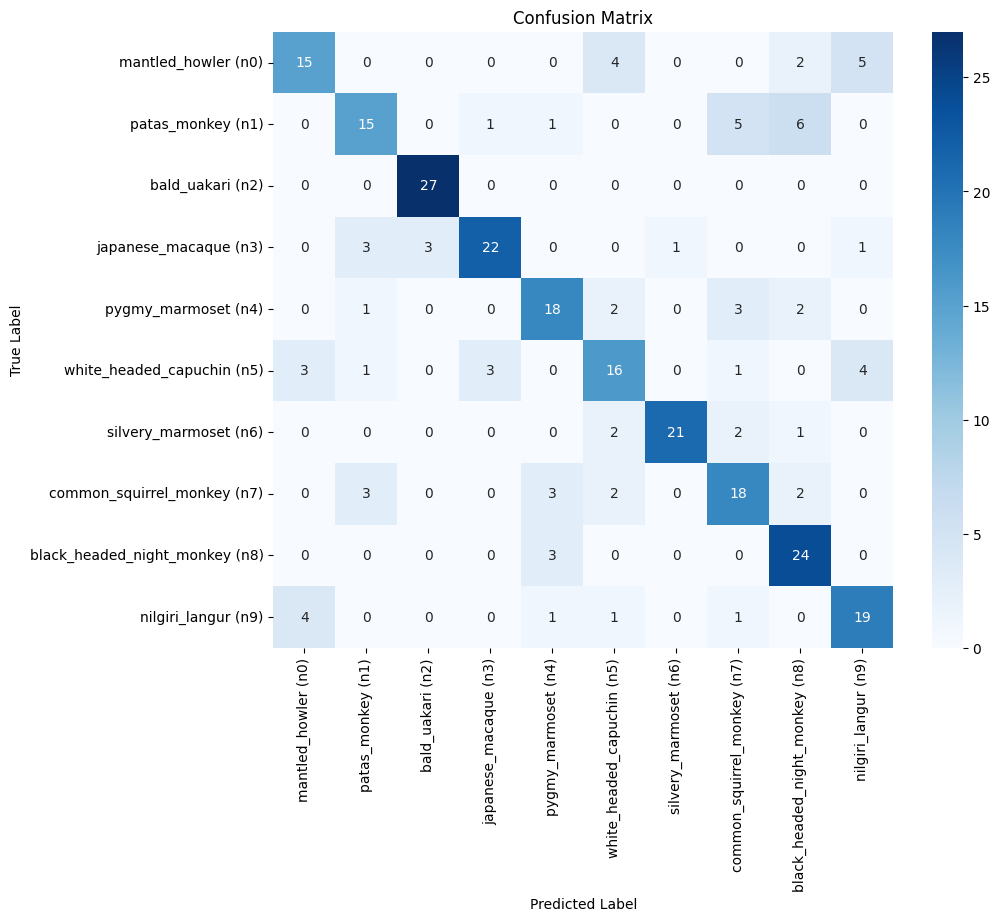

In [ ]:
eval_classes(y_pred, y_true, model, test_load, class_names)

#### Precision, Recall & F1-score per class calculating


In [43]:
def plot_metrics_by_class(model, dataloader, class_names):
    """
    Plot precision, recall, and F1-score metrics for each class in a classification model.

    This function evaluates a trained model on a given dataloader and creates a bar plot
    showing the performance metrics (precision, recall, F1-score) for each class.

    Args:
        model (torch.nn.Module): The trained PyTorch model to evaluate
        dataloader (torch.utils.data.DataLoader): DataLoader containing the evaluation data
        class_names (list): List of class names/labels to display on x-axis

    Returns:
        None, displays a matplotlib plot showing metrics per class

    Notes:
        - Assumes model and data are compatible with PyTorch
        - Uses global 'device' variable for model execution
        - Requires sklearn.metrics for calculating performance metrics
        - Requires matplotlib for visualization
    """
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average=None
    )
    f1macro = f1_score(all_labels, all_preds, average='macro')
    f1micro = f1_score(all_labels, all_preds, average='micro')

    x = np.arange(len(class_names))

    plt.figure(figsize=(24, 8))
    plt.bar(x - 0.2, precision, width=0.2, label="Precision", color="blue")
    plt.bar(x, recall, width=0.2, label="Recall", color="green")
    plt.bar(x + 0.2, f1, width=0.2, label="F1 score", color="red")


    plt.xlabel("Classes")
    plt.ylabel("Score")
    plt.title("Precision, Recall & F1-score per Class")
    plt.xticks(ticks=x, labels=class_names, rotation=45)
    plt.legend()
    plt.show()
    return precision, recall, f1, f1macro, f1micro


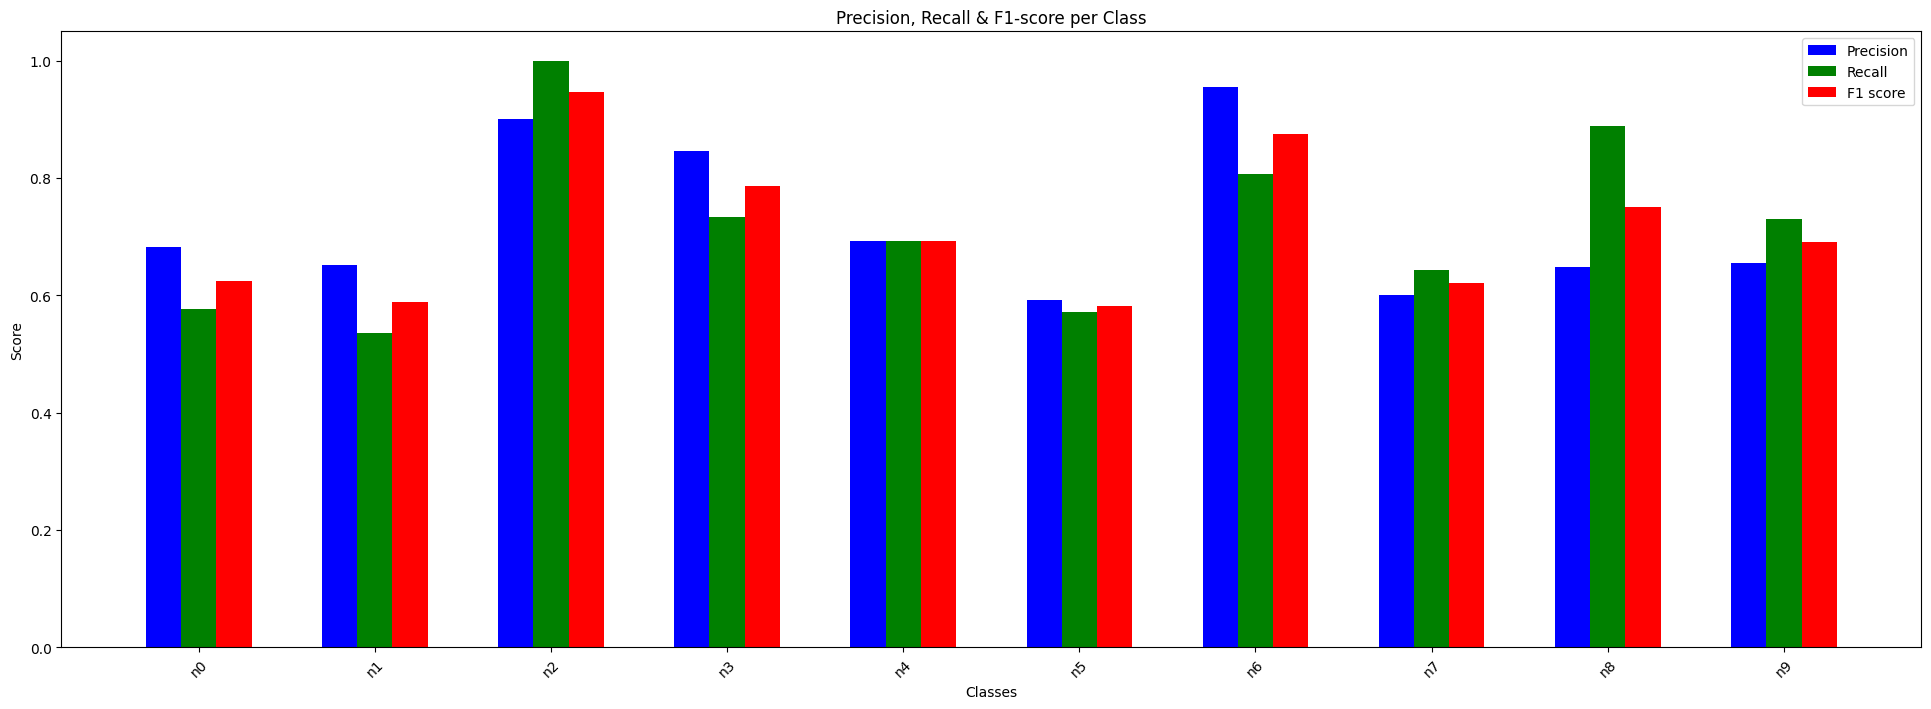

(array([0.68181818, 0.65217391, 0.9       , 0.84615385, 0.69230769,
        0.59259259, 0.95454545, 0.6       , 0.64864865, 0.65517241]),
 array([0.57692308, 0.53571429, 1.        , 0.73333333, 0.69230769,
        0.57142857, 0.80769231, 0.64285714, 0.88888889, 0.73076923]),
 array([0.625     , 0.58823529, 0.94736842, 0.78571429, 0.69230769,
        0.58181818, 0.875     , 0.62068966, 0.75      , 0.69090909]),
 0.7157042621091942,
 0.7169117647058824)

In [44]:
plot_metrics_by_class(model1, test_load, class_names)

#### Accuracy by Class calculation

In [55]:
def plot_accuracy_by_class(model, dataloader, class_names):
    """
    Plots the accuracy of the model by class.

    Args:
        model: The trained PyTorch model.
        dataloader: The DataLoader for the test dataset.
        class_names: A list of class names.

    Returns:
        None
    """
    model.eval()
    correct_per_class = torch.zeros(len(class_names))
    total_per_class = torch.zeros(len(class_names))

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for label, pred in zip(labels, preds):
                total_per_class[label] += 1
                if label == pred:
                    correct_per_class[label] += 1

    accuracy_per_class = (correct_per_class / total_per_class) * 100

    plt.figure(figsize=(10, 5))
    plt.bar(class_names, accuracy_per_class.cpu().numpy(), color="skyblue")
    plt.xlabel("Classes")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy by Class")
    plt.xticks(rotation=45, ha="right")
    plt.ylim(0, 100)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    for i, acc in enumerate(accuracy_per_class.cpu().numpy()):
        plt.text(i, acc + 2, f"{acc:.1f}%", ha="center", fontsize=10, color="black")

    plt.show()


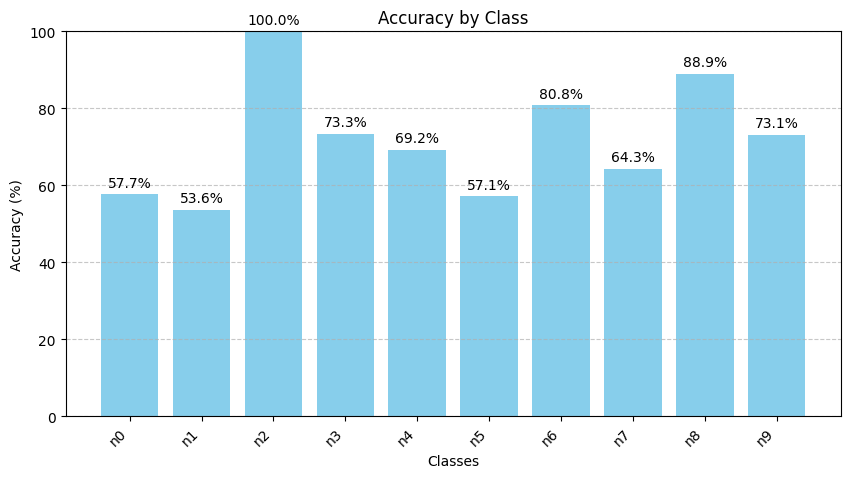

In [56]:
plot_accuracy_by_class(model1, test_load, class_names)

####F1 micro/macro score

In [57]:
def calculate_f1_scores(model, dataloader, class_names):
    """
    Calculates and prints the micro and macro F1 scores.

    Args:
        y_true: A list or numpy array of true labels.
        y_pred: A list or numpy array of predicted labels.
    """
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1macro = f1_score(all_labels, all_preds, average='macro')
    f1micro = f1_score(all_labels, all_preds, average='micro')
    print(f"F1 macro: {f1macro}")
    print(f"F1 micro: {f1micro}")
    return f1macro, f1micro


In [58]:
calculate_f1_scores(model1, test_load, class_names)

F1 macro: 0.7157042621091942
F1 micro: 0.7169117647058824


(0.7157042621091942, 0.7169117647058824)

# Prediction


In [12]:
def predict_and_draw(model, image_path, class_names):
    """
    Predicts the class of an image and displays the image with the predicted label.

    Args:
        model: The trained PyTorch model.
        image_path: The path to the image file.
        class_names: A list of class names.
    """
    transform = transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        model.eval()
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)

    predicted_label = class_names[predicted_class.item()]
    real_label = image_path.split("/")[-2]


    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label}, Real: {real_label}")

    plt.axis("off")
    plt.show()


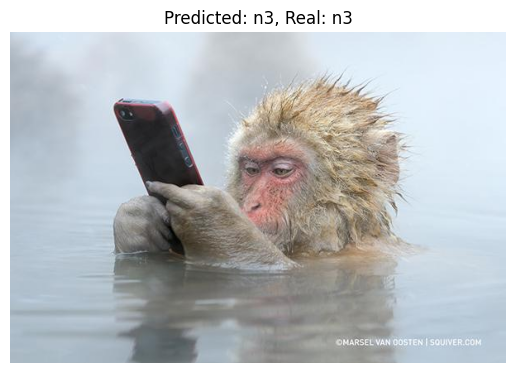

In [45]:
predict_and_draw(model=model1, image_path=f"{path}/training/training/n3/n3021.jpg", class_names=class_names)

# Download and load model

#### Download model


In [ ]:
torch.save(model.state_dict(), 'monkey_classifier.pth')

from google.colab import files
files.download('monkey_classifier.pth')




<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Assuming model

In [11]:
model1 = CNNModel().to(device)
model1.load_state_dict(torch.load('monkey_classifier71.pth'))
model1.eval()

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)